### Load Packages

In [1]:
!pip install ndjson
!pip install -Uqq fastai

     |████████████████████████████████| 189 kB 5.8 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 


In [2]:
import pandas as pd
import ndjson
from fastai.text.all import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from google.colab import drive

### Load Datasets

Training dataset

In [ ]:
# Mount Google Drive
drive.mount('/gdrive')
path_train = Path('/gdrive/MyDrive/industry_data_processed/Preprocessed_data/train_preprocessed.ndjson')

with open(path_train) as f:
    data = ndjson.load(f)
df_train = pd.DataFrame(data)
df_train.head(n=2)

Mounted at /gdrive


,url,industry,industry_label,img_alt,title,h1,h2,h3,strong,bold,lang_code,figcaption
0,http://www.kaiser-personal-service.de,137,Human Resources,,Kaiser Personal Service,,aktuell Stellenangebot,,,,de,
1,http://www.brandseven.com,96,Information Technology and Services,Brandseven Energy Cockpit Innovation Lab Brandseven Go 100 Remote Biohymethcontrol Online Präsentation,Brandseven digital Lösung Energiewirtschaft seit 19 Jahr,Maßgeschneiderte Vertriebstool Stadtwerk Evu s,Brandseven Go 100 Remote Biohymethcontrol richtig erklären – einfach Online Survival Analyse Kausales Modell Basisanalyse,Energy Cockpit 21 Edition,Beispiel Gedankenexperiment Intervention Ergebnis,,de,


In [3]:
# Mount Google Drive
drive.mount('/gdrive')
path_train_con = Path('/gdrive/MyDrive/industry_data_processed/Preprocessed_data/train_preprocessed_concatenated.ndjson')

with open(path_train_con) as f:
    data = ndjson.load(f)
df_train_con = pd.DataFrame(data)
df_train_con.head(n=2)

Mounted at /gdrive


,url,industry,industry_label,img_alt,h1,h2,h3,strong,bold,lang_code,figcaption,pure_text,title,concatenated
0,http://www.kaiser-personal-service.de,137,Human Resources,,,aktuell Stellenangebot,,,,de,,Kaiser Personal Service Impressum Datumenschutz Bewerbung Kp Darmstadt Kp Rheinland suchen Arbeit Staplerfahrer bewerben suchen Arbeit Verkäufer bewerben suchen Arbeit Telefonist bewerben aktuell Stellenangebot Standort wählen Kp Darmstadt Kp Rheinland Kcm Königsfeld Kommunikationselektronik Fernmeldemonteur Elektriker Elektronik Elektronik Raum Darmstadtab Sofortkennziffer Dafmjob Detailsstaplerfahrer Staplerfahrer Biebesheimab Sofortkennziffer Dastjob Detailsmitarbeiter Oberflächentechnik Helfer groß Umstadtab Sofortkennziffer Guotjob Detailssachbearbeiter Tz Zollkenntnissensachbearbeite...,Kaiser Personal Service,aktuell Stellenangebot de Kaiser Personal Service Impressum Datumenschutz Bewerbung Kp Darmstadt Kp Rheinland suchen Arbeit Staplerfahrer bewerben suchen Arbeit Verkäufer bewerben suchen Arbeit Telefonist bewerben aktuell Stellenangebot Standort wählen Kp Darmstadt Kp Rheinland Kcm Königsfeld Kommunikationselektronik Fernmeldemonteur Elektriker Elektronik Elektronik Raum Darmstadtab Sofortkennziffer Dafmjob Detailsstaplerfahrer Staplerfahrer Biebesheimab Sofortkennziffer Dastjob Detailsmitarbeiter Oberflächentechnik Helfer groß Umstadtab Sofortkennziffer Guotjob Detailssachbearbeiter...
1,http://www.brandseven.com,96,Information Technology and Services,Brandseven Energy Cockpit Innovation Lab Brandseven Go Remote Biohymethcontrol Online Präsentation,Maßgeschneiderte Vertriebstool Stadtwerk Evu s,Brandseven Go Remote Biohymethcontrol richtig erklären einfach Online Survival Analyse Kausales Modell Basisanalyse,Energy Cockpit Edition,Beispiel Gedankenexperiment Intervention Ergebnis,,de,,Brandseven digital Lösung Energiewirtschaft seit Jahr Inhalt springen Startenergy Cockpit Übersicht Customer Data Energy Price Energy lib Energy Sales Innovation Labüber Unspartnerjobskontakt Start Energy Cockpit Übersicht Customer Data Energy Price Energy lib Energy Sales Innovation Lab Partner Job Kontakt Energy Cockpit Edition Maßgeschneiderte Vertriebstool Stadtwerk Evu s Cloud basieren fortschrittlich Detail erfahren Energy Cockpit übernehmen Steuer Cloudbasierte Tools neu Bestandskunde Pricing Controlling Vertriebssteuerung vereinen Cockpit individuell anpassen erfahren Blick Kulisse...,Brandseven digital Lösung Energiewirtschaft seit Jahr,Brandseven Energy Cockpit Innovation Lab Brandseven Go Remote Biohymethcontrol Online Präsentation Maßgeschneiderte Vertriebstool Stadtwerk Evu s Brandseven Go Remote Biohymethcontrol richtig erklären einfach Online Survival Analyse Kausales Modell Basisanalyse Energy Cockpit Edition Beispiel Gedankenexperiment Intervention Ergebnis de Brandseven digital Lösung Energiewirtschaft seit Jahr Inhalt springen Startenergy Cockpit Übersicht Customer Data Energy Price Energy lib Energy Sales Innovation Labüber Unspartnerjobskontakt Start Energy Cockpit Übersicht Customer Data Energy Price Energy...


 Test dataset

In [ ]:
# Mount Google Drive
drive.mount('/gdrive')
path_test = Path('/gdrive/MyDrive/industry_data_processed/Preprocessed_data/test_preprocessed.ndjson')

with open(path_test) as f:
    data = ndjson.load(f)
df_test = pd.DataFrame(data)
df_test.head(n=2)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


,url,industry,industry_label,img_alt,title,h1,h2,h3,strong,bold,lang_code,figcaption
0,http://www.expert.de,133,Wholesale,Expert Logo Expert Logo Expert Logo Angebot Woche kw15 Angebot Woche kw15 Angebot Woche kw15 Angebot Woche kw15 Angebot Woche kw15 Angebot Woche kw15 Angebot Woche kw15 Bild Artikel Aktion Symbol V7 Motorhead Origin Akkuhandstaubsauger Artikel Aktion Symbol galaxy a51 Prism Crush Black Otelo Allnet Classic einmalig 39 99 € 19 99 € p m 24 m Laufz Artikel Aktion Symbol galaxy Tab S6 leiden Wi fi Gray Tablet Workforce Wf 2850dwf Schwarz Multifunktionsdrucker Artikel Aktion Symbol Kaffeevollautomat Te657f09de Waschmaschine Wan28298 Artikel Effizienz Skala Nespresso Kapselmaschine env120 w Vert...,"[Elektromarkt, Nähe, Online, Shop, –, Expert]",,Highlight,,registrieren Angebot Kinoerlebnis Haus kaufen Upgrade Homeoffice mehr erfahren Toni ® kaufen gehören zusammen sparen 25 kaufen perfekt Wäsche Umwelt kaufen Happy Payday mehr erfahren 35 € Rabatt Microsoft 365 Family sichern kaufen neu Expert Reparaturservice Mobilgeräte ganz bequem Online abwickeln work From Home Sonos Roam Bosch Cashback Kartenzahlung leicht machen Lg Soundbar kaufen Samsung Neo Qled aktuell Aktion Gewinnspiel Techniktrend Experte Beratung Reparatur Service Montag Service Finanzierung Service Altgerät Entsorgung liefern Abholservice Expert Vorteil Expert Newsletter kosten...,,de,
1,http://www.weight-watchers.de,13,Medical Practice,neu Meinww Meinww mobil Vorschau Fiton Video Workouts ww App mobil Vorschau Rezept ww App mobil Vorschau Mitglied Post ww Community mobil Vorschau individuell Zielsetzung ww App mobil Vorschau Fiton Video Workouts ww App mobil Vorschau Rezept ww App mobil Vorschau Mitglied Post ww Community mobil Vorschau individuell Zielsetzung ww App mobil Vorschau Fiton Video Workouts ww App mobil Vorschau Rezept ww App Junge Frau blond Haaren sitzen lächelnd Handy Hand Junge Frau Rote Haaren lang Rock halten Kaffeebecher Hand Frau lang Haar stehen Küche schneiden Kürbis sportlich gekleidet Frau stehen ...,"[abnehmen, ww, Weight, Watchers, ww, Deutschland]",abnehmen ww Weight Watchers ww Deutschland,kurz Zeit Studios Ort vorübergehend schließen Workshop Lauf wohnen virtuell Termin Workshop Suche haben Frage Antwort,bereit loslegen Mitglied vormachen,ww App kurz Zeit 3 Monat kostenlos „ ww Pro “ exklusiv Community live On demand Premiuminhalte kurz Zeit 3 Monat kostenlos ww Coach Workshop Ort Studio virtuell kurz Zeit 3 Monat kostenlos Neue Fragebogen individuell Bedürfnis Vorliebe abstimmen,,de,


### Build Model

#### Preperation

Defin dependent and independent variables

In [ ]:
# Set dependent variable to 'industry_label'
y = df_train[['industry_label', 'industry']]
# Set independent variable to all columns but 'industry_label', 'industry' & 'url'
X = df_train.drop(columns=['industry_label', 'industry', 'url'])

In [ ]:
# Concatenate predicting columns into one

X['concatenated'] = X[X.columns[1:]].apply(
    lambda column: ' '.join(column.dropna().astype(str)),
    axis=1
)
X.head(n=2)

,img_alt,title,h1,h2,h3,strong,bold,lang_code,figcaption,concatenated
0,,Kaiser Personal Service,,aktuell Stellenangebot,,,,de,,Kaiser Personal Service aktuell Stellenangebot de
1,Brandseven Energy Cockpit Innovation Lab Brandseven Go 100 Remote Biohymethcontrol Online Präsentation,Brandseven digital Lösung Energiewirtschaft seit 19 Jahr,Maßgeschneiderte Vertriebstool Stadtwerk Evu s,Brandseven Go 100 Remote Biohymethcontrol richtig erklären – einfach Online Survival Analyse Kausales Modell Basisanalyse,Energy Cockpit 21 Edition,Beispiel Gedankenexperiment Intervention Ergebnis,,de,,Brandseven digital Lösung Energiewirtschaft seit 19 Jahr Maßgeschneiderte Vertriebstool Stadtwerk Evu s Brandseven Go 100 Remote Biohymethcontrol richtig erklären – einfach Online Survival Analyse Kausales Modell Basisanalyse Energy Cockpit 21 Edition Beispiel Gedankenexperiment Intervention Ergebnis de


In [ ]:
# Concatenate predicting columns into one 
df_train_con = df_train
df_train_con['concatenated'] = df_train_con[df_train_con.columns[3:]].apply(
    lambda column: ' '.join(column.dropna().astype(str)),
    axis=1
)
df_train_con.head(n=2)

,url,industry,industry_label,img_alt,title,h1,h2,h3,strong,bold,lang_code,figcaption,concatenated
0,http://www.kaiser-personal-service.de,137,Human Resources,,Kaiser Personal Service,,aktuell Stellenangebot,,,,de,,Kaiser Personal Service aktuell Stellenangebot de
1,http://www.brandseven.com,96,Information Technology and Services,Brandseven Energy Cockpit Innovation Lab Brandseven Go 100 Remote Biohymethcontrol Online Präsentation,Brandseven digital Lösung Energiewirtschaft seit 19 Jahr,Maßgeschneiderte Vertriebstool Stadtwerk Evu s,Brandseven Go 100 Remote Biohymethcontrol richtig erklären – einfach Online Survival Analyse Kausales Modell Basisanalyse,Energy Cockpit 21 Edition,Beispiel Gedankenexperiment Intervention Ergebnis,,de,,Brandseven Energy Cockpit Innovation Lab Brandseven Go 100 Remote Biohymethcontrol Online Präsentation Brandseven digital Lösung Energiewirtschaft seit 19 Jahr Maßgeschneiderte Vertriebstool Stadtwerk Evu s Brandseven Go 100 Remote Biohymethcontrol richtig erklären – einfach Online Survival Analyse Kausales Modell Basisanalyse Energy Cockpit 21 Edition Beispiel Gedankenexperiment Intervention Ergebnis de


Create `Bag of Words`

In [ ]:
count_vect = CountVectorizer(ngram_range=(1,1))

X_train_counts = count_vect.fit_transform(df_train_con.concatenated)
X_train_counts.shape

(25185, 237489)

In [ ]:
df_train_con.head()

Create `DataLoader`

In [ ]:
dls = TextDataLoaders.from_df(
    bs=32,
    is_lm=True,
    df=df_train_con,
    path=path_train_con,
    text_col='concatenated',
    label_col='industry_label',
    seed=25,
    valid_pct=0.2
)

Create `Language-Model-Learner`

In [ ]:
learn_lang = language_model_learner(dls, AWD_LSTM, metrics=accuracy)

In [ ]:
learn_lang.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

Create Text-Classifier-Learner

In [ ]:
learn_class = text_classifier_learner(dls, AWD_LSTM, metrics=accuracy)

In [ ]:
learn_class.fit(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.307808,2.104628,0.349414,03:52


KeyboardInterrupt: ignored

SuggestedLRs(valley=0.0063095735386013985)

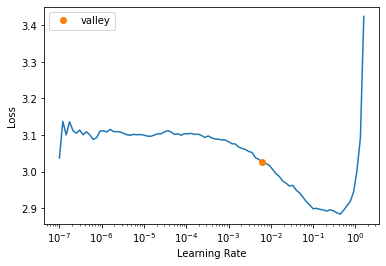

In [ ]:
learn.lr_find()

In [ ]:
def datasaver_to_ndjson(df, name):
  # create flat list in dict form: {'col1': 'value', 'col2': 'value', ...} from df
  flat_list_back = []
  for i in range(len(df)):
    line = df.loc[i].to_dict()
    #line['industry'] = str(line['industry']) # use if idustry number (e.g. 13) should be enclosed in '' (e.g. '13')
    flat_list_back.append([line])

  filename = str(name) + '.ndjson'

  # https://stackoverflow.com/questions/21058935/python-json-loads-shows-valueerror-extra-data
  with open(filename, mode='w') as f:
    for item in flat_list_back:
      f.write('{}\n'.format(ndjson.dumps(item))) 